In [1]:
import tensorflow as tf
from tensorflow.python.ops import init_ops
from tensorflow.python import debug as tf_debug
import numpy as np
from scipy import misc
import sys
import random
import matplotlib.pyplot as plt
from copy import deepcopy, copy
import random
import os
import logging
import pickle
import cv2
from datetime import datetime
from tqdm import tqdm_notebook
import tqdm
%matplotlib inline
print(tf.__version__)

1.14.0


In [2]:
ADD_WRONG = False
def get_cleaned_data():
    empty = 0
    total = 0
    error = 0

    images = []
    for d, dirs, files in tqdm_notebook(list(os.walk('files/grayschema/18/'))):
        for f in files:
            total += 1
            schema_path = os.path.join(d,f)
            try:
                if not os.path.isfile(schema_path):
                    raise RuntimeError("{} doesn't exist".format(schema_path))
                img = cv2.imread(schema_path)
                if (img <= 128).all():
                    empty += 1
                else:
                    relpath = schema_path[len('files/grayschema/'):]
                    sat_path = os.path.join('files/mapbox.satellite/', relpath)
                    if not os.path.isfile(sat_path):
                        raise RuntimeError("{} doesn't exist".format(sat_path))
                    cv2.imread(sat_path)
                    images.append(relpath)
            except Exception as e:
                print(e)
                error += 1
    
    print("Total {}, empty {} {:.2%}, error {}".format(
        total,
        empty, empty * 1.0/ total,
        error))
    
    data = []
    shuffled_images = copy(images)
    random.shuffle(shuffled_images)
    for p ,wp in zip(images, shuffled_images):
        data.append((os.path.join('files/mapbox.satellite/', p),
            os.path.join('files/grayschema/', p), 1, 0))
        if ADD_WRONG:
            data.append((os.path.join('files/mapbox.satellite/', p),
                os.path.join('files/grayschema/', wp), 0, 1))
    random.shuffle(data)
        
    sat_file_paths = []
    schema_file_paths = []
    labels = []
    for item in data:
        sat_file_paths.append(item[0])
        schema_file_paths.append(item[1])
        labels.append(item[2:4])

    return sat_file_paths, schema_file_paths, labels

In [3]:
# sat_file_paths, schema_file_paths, labels = get_cleaned_data()
# with open("cleaned_data.pickle", "wb+") as f:
#     pickle.dump((sat_file_paths, schema_file_paths, labels), f)

In [4]:
with open("cleaned_data.pickle", "rb") as f:
    sat_file_paths, schema_file_paths, labels = pickle.load(f)

In [5]:
def splittvt(arr, frac):
    count = len(arr)
    valid_start = int(count * (1-2*frac))
    test_start = int(count * (1-frac))
    return arr[:valid_start], arr[valid_start: test_start], arr[test_start:]

TST_FRAC = 0.475
train_sat_paths, valid_sat_paths, test_sat_paths = splittvt(sat_file_paths, TST_FRAC)
train_map_paths, valid_map_paths, test_map_paths = splittvt(schema_file_paths, TST_FRAC)
train_labels, valid_labels, test_labels = splittvt(labels, TST_FRAC)
print(len(train_sat_paths), len(valid_sat_paths), len(test_sat_paths))

1243 11808 11809


In [6]:
IMG_SIZE = 256
batch_size = 32
l1_weight = 100
DF_DIM = 64

def read_img(path, f):
    if f == 'png':
        return tf.cast(tf.image.decode_png(tf.read_file(path), channels=1), tf.float32)
    else:
        return tf.cast(tf.image.decode_jpeg(tf.read_file(path)), tf.float32)

In [7]:
all_ops = {}
def encode(data, num_outputs, stride, relu=True, norm=True):
    d = tf.nn.leaky_relu(data)
    all_ops[d.name] = d
    d = tf.layers.Conv2D(
            num_outputs,
            (5, 5),
            strides=stride,
            padding='SAME',
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )(d)
    all_ops[d.name] = d
    if norm:
        d = tf.layers.batch_normalization(
            d,
            momentum=0.9,
            epsilon=1e-5
        )
        all_ops[d.name] = d
    return d


def decode(data, num_outputs, stride, norm=True, dropout=False):
    d = tf.nn.leaky_relu(data)
    d = tf.layers.Conv2DTranspose(
            num_outputs,
            (5, 5),
            strides=stride,
            padding='SAME',
            kernel_initializer=tf.random_normal_initializer(stddev=0.02)
        )(d)
    if norm:
        d = tf.layers.batch_normalization(
            d,
            momentum=0.9,
            epsilon=1e-5
        )

    if dropout:
        d = tf.nn.dropout(d, keep_prob=0.5)
    return d

    
def generator(data):
    with tf.variable_scope("generator"):
        enc_1 = encode(data, DF_DIM, 2, relu=False, norm=False)      # 128 x 128 x 64
        enc_2 = encode(enc_1, DF_DIM * 2, 2)  # 64 x 64 x 128
        enc_3 = encode(enc_2, DF_DIM * 4, 2)  # 32 x 32 x 256
        enc_4 = encode(enc_3, DF_DIM * 8, 2)  # 16 x 16 x 512
        enc_5 = encode(enc_4, DF_DIM * 8, 2)  # 8 x 8 x 512
        enc_6 = encode(enc_5, DF_DIM * 8, 2)  # 4 x 4 x 512
        enc_7 = encode(enc_6, DF_DIM * 8, 2)  # 2 x 2 x 512
        enc_8 = encode(enc_7, DF_DIM * 8, 2)  # 1 x 1 x 512

        dec_7 = decode(enc_8, DF_DIM * 8, 2)  # 2 x 2 x 512

        dec_6 = decode(tf.concat([dec_7, enc_7], 3), DF_DIM * 8, 2, dropout=True)  # 4 x 4 x 512
        dec_5 = decode(tf.concat([dec_6, enc_6], 3), DF_DIM * 8, 2, dropout=True)  # 8 x 8 x 512
        dec_4 = decode(tf.concat([dec_5, enc_5], 3), DF_DIM * 8, 2)  # 16 x 16 x 512
        dec_3 = decode(tf.concat([dec_4, enc_4], 3), DF_DIM * 4, 2)  # 32 x 32 x 256
        dec_2 = decode(tf.concat([dec_3, enc_3], 3), DF_DIM * 2, 2)  # 64 x 64 x 128
        dec_1 = decode(tf.concat([dec_2, enc_2], 3), DF_DIM    , 2)  # 128 x 128 x 64
        result = decode(tf.concat([dec_1, enc_1], 3), 1, 2, norm=False)  # 256 x 256 x 1
    
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
    return result, train_vars

def discriminator(data, reuse=False):
    conv = data
    with tf.variable_scope("discriminator", reuse=reuse):
        conv = encode(conv, DF_DIM, 2)
        conv = encode(conv, DF_DIM * 2, 2)
        conv = encode(conv, DF_DIM * 4, 2)
        conv = encode(conv, DF_DIM * 8, 1)

        hidden = tf.layers.Flatten()(conv)
        logits = tf.layers.Dense(2)(hidden)
        
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    return logits, train_vars


graph = tf.Graph()
with graph.as_default():
    tf_map_files = tf.placeholder(tf.string, name="map_files_placeholder", shape=[batch_size])
    tf_sat_files = tf.placeholder(tf.string, name="sat_files_placeholder", shape=[batch_size])
    
    map_imgs = tf.stack([read_img(path, 'png') for path in tf.unstack(tf_map_files)])
    print("Map imgs, shape", map_imgs.shape)
    sat_imgs = tf.stack([read_img(path, 'jpg') for path in tf.unstack(tf_sat_files)])
    print("Sat imgs, shape", sat_imgs.shape)

    sat_imgs = tf.reshape(sat_imgs, [batch_size, IMG_SIZE, IMG_SIZE, 3])
    fake_map_imgs, generator_vars = generator(
        sat_imgs
    )
    
    tf_data_gt = tf.reshape(tf.concat([
            map_imgs,
            sat_imgs
        ],3), [batch_size, IMG_SIZE, IMG_SIZE, 4])
    tf_data_fake = tf.reshape(tf.concat([
            fake_map_imgs,
            sat_imgs
        ],3), [batch_size, IMG_SIZE, IMG_SIZE, 4])
  
  
    cat_gt = tf.constant(0, shape=[batch_size])
    labels_gt = tf.one_hot(cat_gt, depth=2)
    cat_fake = tf.constant(1, shape=[batch_size])
    labels_fake = tf.one_hot(cat_fake, depth=2)
    tf_labels = tf.concat([labels_gt, labels_fake], axis=0)
        
    d_logits_gt, discriminator_vars = discriminator(tf_data_gt, reuse=False)
    d_logits_fake, _ = discriminator(tf_data_fake, reuse=True)
    
    d_logits = tf.concat([d_logits_gt, d_logits_fake], axis=0)
    
    d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits, labels=tf_labels))
    d_loss_s = tf.summary.scalar('d_loss', d_loss)
    d_global_step = tf.Variable(0)
    d_optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5, beta2=0.999).minimize(
        d_loss, global_step=d_global_step, var_list=discriminator_vars)
    
    l1_loss = tf.reduce_mean(
        tf.math.abs(
            fake_map_imgs - map_imgs
        )
    )
    
    l1_loss_s = tf.summary.scalar("l1_loss", l1_loss)
    
    g_loss_d = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=labels_gt
        ))
    g_loss_d_s = tf.summary.scalar("g_loss_d", g_loss_d)
    g_loss = g_loss_d + l1_weight * l1_loss
    #g_loss = l2_loss
    g_loss_s = tf.summary.scalar("g_loss", g_loss)
    
    g_global_step = tf.Variable(0)
    g_optimizer = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(
        g_loss, global_step=g_global_step, var_list=generator_vars)
    
    prediction = tf.nn.softmax(d_logits)
    #correct = tf.nn.in_top_k(d_logits, tf.math.argmax(tf_labels, 1), 1)
    #count_correct = tf.count_nonzero(correct)
    #acc_s = tf.summary.scalar("acc", count_correct/batch_size)
    
    merged = tf.summary.merge([g_loss_s, g_loss_d_s, l1_loss_s, d_loss_s])
    
    fmi_s = tf.summary.image("fake_map_imgs", fake_map_imgs)
    mi_s = tf.summary.image("map_imgs", map_imgs)
    si_s = tf.summary.image("sat_imgs", sat_imgs)
    merged_images = tf.summary.merge((fmi_s, mi_s, si_s))
    
    #check_op = tf.add_check_numerics_ops()
    saver = tf.train.Saver()

W1022 06:08:58.467499 139754401052480 deprecation.py:323] From <ipython-input-7-77f0e54e6021>:17: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Map imgs, shape (32, ?, ?, 1)
Sat imgs, shape (32, ?, ?, ?)


W1022 06:08:59.046813 139754401052480 deprecation.py:506] From <ipython-input-7-77f0e54e6021>:40: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1022 06:08:59.454290 139754401052480 deprecation.py:506] From /home/enick/venv_python3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1022 06:08:59.695197 139754401052480 deprecation.py:323] From /home/enick/venv_python3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will 

In [8]:
def doEpoch(session, epoch, writer):
    train_dloss = 0.0
    train_gloss = 0.0
    train_correct = 0
    num_batches = (len(train_map_paths) - batch_size) // batch_size + 1
    
    l = list(zip(train_map_paths, train_sat_paths))
    random.shuffle(l)
    train_map_paths_shuffled, train_sat_paths_shuffled = zip(*l)
    
    for step in range(num_batches):
        offset = (step * batch_size) % (len(train_map_paths) - batch_size + 1)
        feed_dict={
            tf_map_files: train_map_paths_shuffled[offset:offset+batch_size],
            tf_sat_files: train_sat_paths_shuffled[offset:offset+batch_size]
        }

        try:
            _,gl, dl, ms, gs = session.run([d_optimizer, g_loss, d_loss, merged, d_global_step], feed_dict=feed_dict)
            writer.add_summary(ms, gs)

            _,gl, dl, ms, gs = session.run([g_optimizer, g_loss, d_loss, merged, g_global_step], feed_dict=feed_dict)
            train_dloss += dl
            train_gloss += gl
        
            writer.add_summary(ms, gs)
        except:
            print(step)
            print(feed_dict)
            raise
        if step % 30 == 3:
            preview_offset = 1000
            feed_dict={
                tf_map_files: train_map_paths[preview_offset:preview_offset+batch_size],
                tf_sat_files: train_sat_paths[preview_offset:preview_offset+batch_size]
            }

            mis, = session.run([merged_images],feed_dict)
            writer.add_summary(mis, gs)

    return train_dloss / num_batches, train_gloss / num_batches
    
tf.logging.set_verbosity(tf.logging.INFO)
tf.debugging.set_log_device_placement(True)

In [9]:
EPOCHS = 30

run_id="20"
checkpoints_path = "checkpoints/checkpoint_{}".format(run_id)

In [ ]:
train_writer = tf.summary.FileWriter("./summary/generator_{}".format(run_id), graph=graph)

with tf.Session(graph=graph) as session:
    #with tf_debug.TensorBoardDebugWrapperSession(session, "localhost:8008") as session:
        #saver.recover_last_checkpoints(checkpoints_path)
#         try:
#             print("Restoring from previous run...", flush=True)
#             saver.restore(session, checkpoints_path)
#         except:
#             print("Initializing variables...", flush=True)
        tf.global_variables_initializer().run()

        print(datetime.now(), "Initialized.", flush=True)
        for epoch in tqdm_notebook(range(EPOCHS)):
            dloss, gloss = doEpoch(session, epoch, train_writer)
            if epoch % 1 == 0:
                print(datetime.now(), "{} dloss: {:.6f}, gloss: {:.6f}".format(
                    epoch, dloss, gloss), flush=True)
            saver.save(session, checkpoints_path)
        print(datetime.now(), "{} dloss: {:.6f}, gloss: {:.6f}".format(
                    epoch, dloss, gloss), flush=True)

2019-10-22 06:09:05.785122 Initialized.


2019-10-22 06:09:53.255093 0 dloss: 18.613449, gloss: 8904.103599
2019-10-22 06:10:42.393006 1 dloss: 1.175637, gloss: 3872.144743
2019-10-22 06:11:30.688629 2 dloss: 0.344482, gloss: 3366.060585
2019-10-22 06:12:19.188809 3 dloss: 0.740353, gloss: 3240.755185
2019-10-22 06:13:07.475650 4 dloss: 0.328196, gloss: 3062.717372
2019-10-22 06:13:56.223586 5 dloss: 0.418898, gloss: 2792.768137
2019-10-22 06:14:45.732649 6 dloss: 0.320171, gloss: 2810.261963


In [10]:
with tf.Session(graph=graph) as session: 
    saver.restore(session, checkpoints_path))

    offset = 0
    feed_dict={
        tf_map_files: train_map_paths[offset:offset+batch_size],
        tf_sat_files: train_sat_paths[offset:offset+batch_size],
    }
    generated = session.run([fake_map_imgs], feed_dict=feed_dict)

W1019 07:16:51.938389 139746396202816 deprecation.py:323] From /home/enick/venv_python3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I1019 07:16:51.939760 139746396202816 saver.py:1280] Restoring parameters from checkpoints/checkpoint_6


In [10]:
all_ops.keys()

dict_keys(['generator/LeakyRelu:0', 'generator/conv2d/BiasAdd:0', 'generator/LeakyRelu_1:0', 'generator/conv2d_1/BiasAdd:0', 'generator/batch_normalization/FusedBatchNorm:0', 'generator/LeakyRelu_2:0', 'generator/conv2d_2/BiasAdd:0', 'generator/batch_normalization_1/FusedBatchNorm:0', 'generator/LeakyRelu_3:0', 'generator/conv2d_3/BiasAdd:0', 'generator/batch_normalization_2/FusedBatchNorm:0', 'generator/LeakyRelu_4:0', 'generator/conv2d_4/BiasAdd:0', 'generator/batch_normalization_3/FusedBatchNorm:0', 'generator/LeakyRelu_5:0', 'generator/conv2d_5/BiasAdd:0', 'generator/batch_normalization_4/FusedBatchNorm:0', 'generator/LeakyRelu_6:0', 'generator/conv2d_6/BiasAdd:0', 'generator/batch_normalization_5/FusedBatchNorm:0', 'generator/LeakyRelu_7:0', 'generator/conv2d_7/BiasAdd:0', 'generator/batch_normalization_6/FusedBatchNorm:0', 'discriminator/LeakyRelu:0', 'discriminator/conv2d/BiasAdd:0', 'discriminator/batch_normalization/FusedBatchNorm:0', 'discriminator/LeakyRelu_1:0', 'discrimina

In [17]:
a = tf.constant(0, shape=[10])
b = tf.constant(1, shape=[10])
c = tf.concat([a, b], axis=0)
d = tf.one_hot(c, 2)

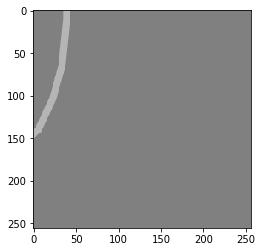

In [22]:
plt.imshow(cv2.imread(train_map_paths[1002]))

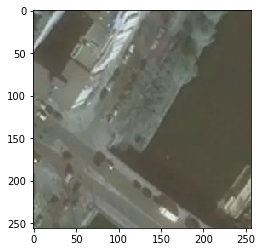

In [24]:
plt.imshow(cv2.imread(train_sat_paths[1001]))